## **Perform evaluation using the Vertex Gen AI SDK**

---


In [1]:
!pip install --upgrade google-cloud-aiplatform[evaluation]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 73.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 41.2 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-aiplatform
    Found existing installation: google-cloud-aiplatform 1.108.0
    Uninstalling google-cloud-aiplatform-1.108.0:
      Successfully uninstalled google-cloud-aiplatform-1.108.0


In [2]:
from google.colab.auth import authenticate_user
try:
  authenticate_user()
except Exception as e:
  print(f"Authentication failed: {e}")
  print("Please make sure you are logged into a Google Account.")

In [8]:
import pandas as pd
from vertexai import Client, types

client = Client(project="devhack-3f0c2", location="us-central1")

prompts_df = pd.DataFrame({"prompt": ["How are Chilaquiles prepared?", "What are the agents"]})

### **Evaluating a single model**

**Criteria:** The dimensions you want to evaluate, such as conciseness, relevance, correctness, or appropriate choice of words.

**Metrics:** A score that measures the model output against the defined criteria.

The Gen AI evaluation service provides two main types of metrics:

**Model-based metrics:** These metrics use a powerful "judge" model to assess your model's performance. For most use cases, the judge model is Gemini, but you can also use models like MetricX or COMET for translation tasks. You can measure model-based metrics in two ways:

**Pointwise:** The judge model assesses your model's output based on your evaluation criteria.

**Pairwise:** The judge model compares the responses of two models and selects the better one. This method is often used to compare a candidate model to a baseline model and is only supported with Gemini as the judge model.

**Computation-based metrics:** These metrics use mathematical formulas to compare a model's output to a ground truth or reference answer. Common examples include ROUGE and BLEU.

In [9]:
eval_dataset = client.evals.run_inference(
    model="gemini-2.5-flash",
    src=prompts_df,
)

eval_result = client.evals.evaluate(
    dataset=eval_dataset,
    metrics=[types.PrebuiltMetric.TEXT_QUALITY, types.PrebuiltMetric.COHERENCE, types.PrebuiltMetric.FLUENCY, types.PrebuiltMetric.GROUNDEDNESS]
)

eval_result.show()

Computing Metrics for Evaluation Dataset: 100%|██████████| 8/8 [00:01<00:00,  6.09it/s]


### **Compare multiple candidates**

In [14]:
candidate_1 = client.evals.run_inference(
    model="gemini-2.5-flash",
    src=prompts_df,
)

candidate_2 = client.evals.run_inference(
    model="gemini-2.0-flash",
    src=prompts_df,
)

comparison_result = client.evals.evaluate(
    dataset=[candidate_1, candidate_2],
    metrics=[types.PrebuiltMetric.TEXT_QUALITY]
)

comparison_result.show()

Computing Metrics for Evaluation Dataset: 100%|██████████| 4/4 [00:01<00:00,  3.76it/s]


### **LLM-based metrics**

In [16]:
eval_dataset = client.evals.run_inference(
    model="gemini-2.0-flash",
    src=prompts_df,
)

eval_result = client.evals.evaluate(
    dataset=eval_dataset,
    metrics=[
        types.PrebuiltMetric.TEXT_QUALITY,
        types.PrebuiltMetric.INSTRUCTION_FOLLOWING,
    ]
)

eval_result.show()

Computing Metrics for Evaluation Dataset: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]


### **Define a custom metric to evaluate**

In [17]:
simplicity_metric = types.LLMMetric(
    name='language_simplicity',
    prompt_template=types.MetricPromptBuilder(
        instruction="Evaluate the story's simplicity for a 5-year-old.",
        criteria={
            "Vocabulary": "Uses simple words.",
            "Sentences": "Uses short sentences.",
        },
        rating_scores={
            "5": "Excellent: Very simple, ideal for a 5-year-old.",
            "4": "Good: Mostly simple, with minor complex parts.",
            "3": "Fair: Mix of simple and complex; may be challenging for a 5-year-old.",
            "2": "Poor: Largely too complex, with difficult words/sentences.",
            "1": "Very Poor: Very complex, unsuitable for a 5-year-old."
        }
    )
)

eval_result = client.evals.evaluate(
    dataset=eval_dataset,
    metrics=[simplicity_metric]
)

eval_result.show()

Computing Metrics for Evaluation Dataset: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]


### **Computation-based and custom function metrics**

**Computation-based metrics** mathematically compare a model's output to a ground truth or reference. These metrics are calculated with code using the base Metric class and support predefined algorithms such as exact_match, bleu, and rouge_1. To use a computation-based metric, instantiate the Metric class with the metric's name. The metric requires a reference column in your dataset for comparison.

In [18]:
import pandas as pd

# let's create responses and put references
prompts_df = pd.DataFrame({
    "prompt": [
        "What is the capital of France?",
        "Who wrote 'Hamlet'?",
    ],
    "reference": [
        "Paris",
        "William Shakespeare",
    ]
})

inference_results = client.evals.run_inference(
    model="gemini-2.5-flash",
    src=prompts_df
)

inference_results.show()

Gemini Inference: 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]


In [21]:
# Computation-based metrics
eval_result = client.evals.evaluate(
    dataset=inference_results,
    metrics=[
        types.Metric(name='exact_match'),
        types.Metric(name='bleu'),
        types.Metric(name='rouge_1'),
    ]
)

eval_result.show()

Computing Metrics for Evaluation Dataset: 100%|██████████| 6/6 [00:00<00:00, 46.25it/s]


### **Evaluating third-party models**

You can use the Vertex Gen AI Eval SDK to evaluate and compare models from providers such as OpenAI. The SDK uses the **litellm** library to call third-party model APIs

In [29]:
import os
from google.colab import userdata

# Set your third-party model API key
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Run inference on an OpenAI model
gpt_response = client.evals.run_inference(
    model='gpt-4o',
    src=prompts_df
)

gemini_response = client.evals.run_inference(
    model='gemini-2.0-flash',
    src=prompts_df
)


# You can now evaluate the responses
eval_result = client.evals.evaluate(
    dataset=[gpt_response, gemini_response],
    metrics=[types.PrebuiltMetric.TEXT_QUALITY, types.PrebuiltMetric.COHERENCE, types.PrebuiltMetric.FLUENCY, types.PrebuiltMetric.VERBOSITY]
)

eval_result.show()

Computing Metrics for Evaluation Dataset: 100%|██████████| 16/16 [00:02<00:00,  6.73it/s]


In [30]:
eval_result.dict()

{'eval_case_results': [{'eval_case_index': 0,
   'response_candidate_results': [{'response_index': 0,
     'metric_results': {'text_quality': {'metric_name': 'text_quality',
       'score': 5.0,
       'explanation': 'The response is clear, coherent, fluent, and concise, fully adhering to the instruction and staying grounded by providing a correct and direct answer.',
       'rubric_verdicts': None,
       'raw_output': None,
       'error_message': None},
      'coherence': {'metric_name': 'coherence',
       'score': 5.0,
       'explanation': 'The response is completely coherent as it provides a direct and accurate answer to the question, demonstrating a seamless logical flow.',
       'rubric_verdicts': None,
       'raw_output': None,
       'error_message': None},
      'fluency': {'metric_name': 'fluency',
       'score': 5.0,
       'explanation': 'The response is grammatically correct, uses clear and appropriate word choice, and flows naturally.',
       'rubric_verdicts': Non

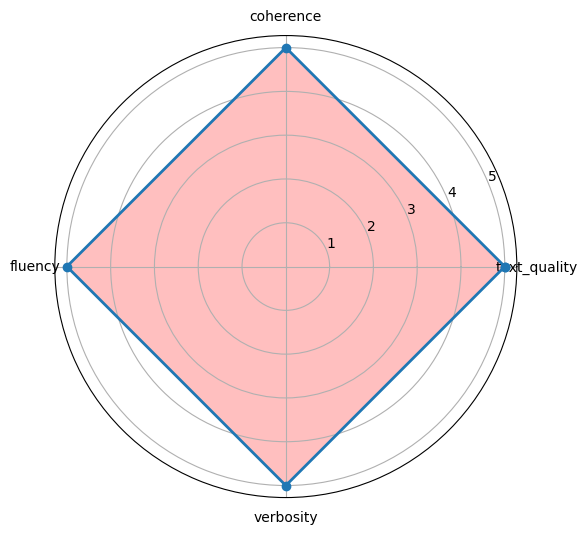

In [33]:
import matplotlib.pyplot as plt
import numpy as np

summary_metrics = eval_result.dict()['summary_metrics']

labels = [metric['metric_name'] for metric in summary_metrics]
stats = [metric['mean_score'] for metric in summary_metrics]

# Handle verbosity metric: lower is better, so invert score for visualization
for i, label in enumerate(labels):
    if label == 'verbosity':
        stats[i] = 5 - stats[i]  # Assuming a max score of 5 for other metrics

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
stats = stats + stats[:1]
angles = angles + angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.fill(angles, stats, color='red', alpha=0.25)
ax.plot(angles, stats, 'o-', linewidth=2)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.grid(True)

plt.show()